## Prediction Model based on Genres


### Model 1: generate list of movie recommendation based on "genres" + "rating".
- Input from user: genres
- scores are calculated and ranked to produce the top 5 movies
- In this notebook, I will offer 2 simple way:
    - based on rating score alone
    - based on rating score and genre picked by the user
- Features include: 
    - genres
    - movie rating score (based on IMDB formula)

In [1]:
import pandas as pd

pd.set_option("display.max_columns", 85)
pd.set_option("display.max_rows", 85)
df = pd.read_csv('../../edit_data/Lee/cleaned_data/movies_main.csv')  
df.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",['Grumpy Old Men Collection'],['English'],"['Warner Bros.', 'Lancaster Gate']",['United States of America'],['US'],"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","['fishing', 'best friend', 'duringcreditssting...","['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",['Howard Deutch']
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",NaN,['English'],['Twentieth Century Fox Film Corporation'],['United States of America'],['US'],"[{'id': 818, 'name': 'based on novel'}, {'id':...","['based on novel', 'interracial relationship',...","['Whitney Houston', 'Angela Bassett', 'Loretta...",['Forest Whitaker']
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],['Father of the Bride Collection'],['English'],"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],['US'],"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","['baby', 'midlife crisis', 'confidence', 'agin...","['Steve Martin', 'Dian

Method 1: step 1 - calculate the C and m values.

In [2]:
## To calculate the mean value of Vote Average
C= df['Vote_Average'].mean()
C

5.6259312895463855

In [3]:
## set vote count threshold to 90 %tile.
m= df['Vote_Count'].quantile(0.90)
m

163.0

Method 1: Step 2 - Set qualified Movies (The Filter)
- Qualified movies are set based on Number of Vote Count received by the movies. 
- To qualified, the movies must has be at 90 %tile in total vote counts (i.e. 163 votes or more)
- This is where we would set the ['Genres']' as a filter. 

Filter 1: m-value only

In [110]:
## only filter based on m value
# qualified_movies = df.copy().loc[df['Vote_Count'] >= m]
# qualified_movies.shape


Filter 2: m-value + genres (entered by user)

Re-Parse Genres again to a new column (the parsed column is not working)

In [4]:
import ast
import numpy as np

# Function to parse the string and extract 'name'
def extract_names(data_string):
    if pd.isna(data_string):
        return np.nan
    try:
        # Safely evaluate the string to a Python object
        data_object = ast.literal_eval(data_string)
        if isinstance(data_object, list):
            # Extract 'name' from each dictionary in the list
            names = [item['name'] for item in data_object]
            return names
        elif isinstance(data_object, dict):
            # Extract 'name' from the dictionary
            return [data_object.get('name', np.nan)]
    except (ValueError, SyntaxError):
        return np.nan
    
    
df['Genres_Parse_new'] = df['Genres'].apply(extract_names)

In [5]:
### TEST : to generate a unique list of genres

# Flatten the list of genres, ignoring NaN values, and extract unique values
unique_genres = set(
    genre
    for sublist in df['Genres_Parse_new'].dropna()  # Drop NaN values
    for genre in sublist
)

# Convert the set to a sorted list (optional)
unique_genres_list = sorted(unique_genres)

# Display the unique genres
print(unique_genres_list)
print(len(unique_genres_list))

['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
20


Request user to enter the Genre
- codes can be enhanced to avoid typo, etc. 

In [6]:

# Genres List in total (20)
genres_list= ['Action', 'Adventure', 'Animation', 
              'Comedy', 'Crime', 'Documentary', 
              'Drama', 'Family', 'Fantasy', 
              'Foreign', 'History', 'Horror', 
              'Music', 'Mystery', 'Romance', 
              'Science Fiction', 'TV Movie', 
              'Thriller', 'War', 'Western']

print('total genres:', len(genres_list))

genre_input = input("Enter the genre: ")

if genre_input in genres_list:
    filt = (df['Vote_Count'] >= m) & (df['Genres_Parse_new'].apply(lambda x: genre_input in x if isinstance(x, list) else False) )
    qualified_movies = df.copy().loc[filt]
    print("You have selected the genre: ", genre_input)
    print("qualified_movies: ", qualified_movies.shape)
else:
    print("wrong genre entered.")
    Game_is_on = False



total genres: 20
You have selected the genre:  Animation
qualified_movies:  (363, 29)


Method 1: step 3 - set up the rating score calculation

In [7]:
def weighted_rating(x, m=m, C=C):
    v = x['Vote_Count']
    R = x['Vote_Average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [8]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
qualified_movies['Score'] = qualified_movies.apply(weighted_rating, axis=1)

qualified_movies.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse,Genres_Parse_new,Score
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter'],"[Animation, Comedy, Family]",7.639392
12,21032,Balto,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,11348324.0,78.0,1995-12-22,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0112453,12.140733,7.1,423.0,"{'id': 117693, 'name': 'Balto Collection', 'po...",Part Dog. Part Wolf. All Hero.,An outcast half-wolf risks his life to prevent...,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...","['Family', 'Animation', 'Adventure']",['Balto Collection'],['English'],"['Universal Pictures', 'Amblin Entertainment',...",['United States of America'],['US'],"[{'id': 1994, 'name': 'wolf'}, {'id': 6411, 'n...","['wolf', 'dog-sledding race', 'alaska', 'dog',...","['Kevin Bacon', 'Bob Hoskins', 'Bridget Fonda'...",['Simon Wells'],"[Family, Animation, Adventure]",6.689977
47,10530,Pocahontas,en,"[{'iso_639_1': 'en', 'name': 'English'}]",55000000.0,346079773.0,81.0,1995-06-14,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114148,13.280069,6.7,1509.0,"{'id': 136214, 'name': 'Pocahontas Collection'...",An American legend comes to life.,History comes gloriously to life in Disney's e...,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...","['Adventure', 'Animation', 'Drama', 'Family']",['Pocahontas Collection'],['English'],"['Walt Disney Pictures', 'Walt Disney Feature ...",['United States of America'],['US'],"[{'id': 1463, 'name': 'culture clash'}, {'id':...","['culture clash', 'settler', 'forbidden love',...","['Irene Bedard', 'Mel Gibson', 'David Ogden St...","['Mike Gabriel', 'Eric Goldberg']","[Adventure, Animation, Drama, Family]",6.595291
234,15789,A Goofy Movie,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,35348597.0,78.0,1995-04-07,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113198,10.177977,6.7,404.0,"{'id': 410261, 'name': 'A Goofy Movie Collecti...",It's the story of a father who couldn't be clo...,"Though Goofy always means well, his amiable cl...","[{'id': 10749, 'name': 'Romance'}, {'id': 16, ...","['Romance', 'Animation', 'Family', 'Comedy', '...",['A Goofy Movie Collection'],['English'],['Walt Disney Pictures'],['United States of America'],['US'],"[{'id': 494, 'name': 'father son relationship'...","['father son relationship', 'pop singer', 'mus...","['Bill Farmer', 'Jason Marsden', 'Rob Paulsen'...","['Kevin Lima', 'Paul Brizzi']","[Romance, Animation, Family, Comedy, Adventure]",6.391229
308,22586,The Swan Princess,en,"[{'iso_639_1': 'en', 'name': 'English'}]",35000000.0,9771658.0,89.0,1994-11-18,"[{'name': 'Rich Animation Studios', 'id': 4108}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0111333,8.910462,6.5,251.0,"{'id': 144200, 'name': 'Swan Princess Series',...",An enchanting classic destined to capture your...,The 

Method 1: step 4 - create the movie recommendation based on the Score

In [9]:
#Sort movies based on score calculated above
qualified_movies = qualified_movies.sort_values('Score', ascending=False)

#Print the top 5 movies
print("Genre you have chosen:      ", genre_input)
print("Number of qualified movies: ", qualified_movies.shape)
qualified_movies[['Original_Title', 'Genres_Parse_new','Vote_Count','Vote_Average', 'Popularity','Score']].head(5)

Genre you have chosen:       Animation
Number of qualified movies:  (363, 30)


,Original_Title,Genres_Parse_new,Vote_Count,Vote_Average,Popularity,Score
5455,千と千尋の神隠し,"[Fantasy, Adventure, Animation, Family]",3968.0,8.3,41.048867,8.194487
39799,君の名は。,"[Romance, Animation, Drama]",1030.0,8.5,34.461252,8.107315
9648,ハウルの動く城,"[Fantasy, Animation, Adventure]",2049.0,8.2,16.136048,8.010320
2870,もののけ姫,"[Adventure, Fantasy, Animation]",2041.0,8.2,17.166725,8.009631
358,The Lion King,"[Family, Animation, Drama]",5520.0,8.0,21.605761,7.931907


### Model 2: Simple Linear KNN Model by Score

- KNN Regression Model
- input (features, X):
    - ['Vote_Average']
    - [''Vote_Count']
    - ['Budget']
    - ['Revenue']
    - [-'Runtime']
- Output (Target, y): ['Score']

In [228]:
# load the data
df.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter']
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston']
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",['Grumpy Old Men Collection'],['English'],"['Warner Bros.', 'Lancaster Gate']",['United States of America'],['US'],"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","['fishing', 'best friend', 'duringcreditssting...","['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",['Howard Deutch']
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",NaN,['English'],['Twentieth Century Fox Film Corporation'],['United States of America'],['US'],"[{'id': 818, 'name': 'based on novel'}, {'id':...","['based on novel', 'interracial relationship',...","['Whitney Houston', 'Angela Bassett', 'Loretta...",['Forest Whitaker']
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],['Father of the Bride Collection'],['English'],"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],['US'],"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","['baby', 'midlife crisis', 'confidence', 'agin...","['Steve Martin', 'Dian

In [ ]:
### NOT USING THIS 
#create a mapping of unique title and Id
# lookup_title = dict(zip(df.Id.unique(), df.Original_Title.unique()))
# lookup_title

In [233]:
# add Score as a new column
df['Score'] = df.apply(weighted_rating, axis=1)
df.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse,Score
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter'],7.639392
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston'],6.819382
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",['Grumpy Old Men Collection'],['English'],"['Warner Bros.', 'Lancaster Gate']",['United States of America'],['US'],"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","['fishing', 'best friend', 'duringcreditssting...","['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",['Howard Deutch'],5.941282
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",NaN,['English'],['Twentieth Century Fox Film Corporation'],['United States of America'],['US'],"[{'id': 818, 'name': 'based on novel'}, {'id':...","['based on novel', 'interracial relationship',...","['Whitney Houston', 'Angela Bassett', 'Loretta...",['Forest Whitaker'],5.707750
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],['Father of the Bride Collection'],['English'],"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],['US'],"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","['baby', 'midlife crisis', 'conf

Prepare the DF for Model

In [242]:
df2 = df[['Vote_Average','Vote_Count','Budget','Revenue','Runtime','Score']].copy()

#drop records if no values in these 3 columns: daszDXf[['Vote_Average','Score','Runtime']]
df2.dropna(axis="index", how="all", subset=['Vote_Average','Vote_Count','Budget','Revenue','Runtime','Score'], inplace=True)

print(df2.shape)
print(df2.head())

(44884, 6)
   Vote_Average  Vote_Count      Budget      Revenue  Runtime     Score
0           7.7      5415.0  30000000.0  373554033.0     81.0  7.639392
1           6.9      2413.0  65000000.0  262797249.0    104.0  6.819382
2           6.5        92.0         0.0          0.0    101.0  5.941282
3           6.1        34.0  16000000.0   81452156.0    127.0  5.707750
4           5.7       173.0         0.0   76578911.0    106.0  5.664068


Plot the Training and Test set
- plot a scatter matrix
- 75-25 for default train_test_split

In [249]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = df[['Vote_Average','Vote_Count','Budget','Revenue','Runtime']]
y = df['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Create KNN Regression: 
- option 1: Imputate X with NaN + remove NaN in rows for Y, 

In [251]:
# Step 0 - drop rows where y is NaN
not_nan_indices = ~np.isnan(y)
X = X.loc[not_nan_indices]
y = y[not_nan_indices]

# Step 1: Imputation - Replace NaN with the mean of each column
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 2: Verify that there are no NaN values left in the data
print("Are there any NaN values after imputation?")
print(pd.DataFrame(X_imputed).isna().sum())  # Should output 0 for each column

# Step 3: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Step 4: Fit the KNN Regressor model
knnreg = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
print("Predictions:", knnreg.predict(X_test))
print('R-squared test score: {:.3f}'.format(knnreg.score(X_test, y_test)))

Are there any NaN values after imputation?
0    0
1    0
2    0
3    0
4    0
dtype: int64
Predictions: [5.72256889 5.67225629 5.62593129 ... 5.78875609 5.63735532 5.53499975]
R-squared test score: 0.340


Option 2: Imputate both X and y with NaN.

In [252]:
# Step 1: Impute missing values in X
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(X)

# Step 2: Impute missing values in y
imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(y.reshape(-1, 1)).ravel()  # ravel() to return to original shape

# Step 3: Check that there are no NaN values left in y
print("Are there any NaN values in y after imputation?")
print(np.isnan(y_imputed).sum())  # Should output 0

# Step 4: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.2, random_state=42)

# Step 5: Fit the KNN Regressor model
knnreg = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

# Step 6: Make predictions and evaluate the model
print("Predictions:", knnreg.predict(X_test))
print('R-squared test score: {:.3f}'.format(knnreg.score(X_test, y_test)))

AttributeError: 'Series' object has no attribute 'reshape'

### Model 3: Text Clustering 

- The idea would be to create a number of text clusters based on ['Overview']. 
- use clusters to predict -> genres -> top 5 movies recommendations
- GUI: through the clusters, create a set of short quiz users would take to pick the words and then provide the recommendation.

In [16]:
# load the data
df.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse,Genres_Parse_new
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter'],"[Animation, Comedy, Family]"
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston'],"[Adventure, Fantasy, Family]"
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",['Grumpy Old Men Collection'],['English'],"['Warner Bros.', 'Lancaster Gate']",['United States of America'],['US'],"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","['fishing', 'best friend', 'duringcreditssting...","['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",['Howard Deutch'],"[Romance, Comedy]"
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",NaN,['English'],['Twentieth Century Fox Film Corporation'],['United States of America'],['US'],"[{'id': 818, 'name': 'based on novel'}, {'id':...","['based on novel', 'interracial relationship',...","['Whitney Houston', 'Angela Bassett', 'Loretta...",['Forest Whitaker'],"[Comedy, Drama, Romance]"
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],['Father of the Bride Collection'],['English'],"['Sandollar Productions', 'Touchstone Pictures']",['United States of America'],['US'],"[

In [24]:
# Step 3: Data preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# convert dtype to unicode
# use only ['Overview'] now, can potentially add other data such as ['cast', 'crew', keywords, tagline]
documents = df['Keywords_parse'].values.astype("U")

vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents)

In [25]:
# we use K=20 for demo for now.
# TODO: calculate the SSE and plot it against K to get the elbow number of K.

k = 9
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(features)

KMeans(max_iter=100, n_clusters=9, n_init=1)

In [26]:
df['cluster'] = model.labels_
df.head()

,Id,Original_Title,Original_Language,Spoken_Languages,Budget,Revenue,Runtime,Release_Date,Production_Companies,Production_Countries,imdb_id,Popularity,Vote_Average,Vote_Count,Belongs_To_Collection,Tagline,Overview,Genres,Genres_Parse,Belongs_To_Collection_Parse,Spoken_Languages_Parse,Production_Companies_Parse,Production_Countries_Parse,Production_Countries_Code_Parse,Keywords,Keywords_parse,Cast_parse,Director_parse,Genres_Parse_new,cluster
0,862,Toy Story,en,"[{'iso_639_1': 'en', 'name': 'English'}]",30000000.0,373554033.0,81.0,1995-10-30,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114709,21.946943,7.7,5415.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","['Animation', 'Comedy', 'Family']",['Toy Story Collection'],['English'],['Pixar Animation Studios'],['United States of America'],['US'],"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","['jealousy', 'toy', 'boy', 'friendship', 'frie...","['Tom Hanks', 'Tim Allen', 'Don Rickles', 'Jim...",['John Lasseter'],"[Animation, Comedy, Family]",3
1,8844,Jumanji,en,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",65000000.0,262797249.0,104.0,1995-12-15,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113497,17.015539,6.9,2413.0,NaN,Roll the dice and unleash the excitement!,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","['Adventure', 'Fantasy', 'Family']",NaN,"['English', 'Français']","['TriStar Pictures', 'Teitler Film', 'Intersco...",['United States of America'],['US'],"[{'id': 10090, 'name': 'board game'}, {'id': 1...","['board game', 'disappearance', ""based on chil...","['Robin Williams', 'Jonathan Hyde', 'Kirsten D...",['Joe Johnston'],"[Adventure, Fantasy, Family]",0
2,15602,Grumpier Old Men,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,0.0,101.0,1995-12-22,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113228,11.712900,6.5,92.0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",Still Yelling. Still Fighting. Still Ready for...,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","['Romance', 'Comedy']",['Grumpy Old Men Collection'],['English'],"['Warner Bros.', 'Lancaster Gate']",['United States of America'],['US'],"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","['fishing', 'best friend', 'duringcreditssting...","['Walter Matthau', 'Jack Lemmon', 'Ann-Margret...",['Howard Deutch'],"[Romance, Comedy]",0
3,31357,Waiting to Exhale,en,"[{'iso_639_1': 'en', 'name': 'English'}]",16000000.0,81452156.0,127.0,1995-12-22,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",tt0114885,3.859495,6.1,34.0,NaN,Friends are the people who let you be yourself...,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","['Comedy', 'Drama', 'Romance']",NaN,['English'],['Twentieth Century Fox Film Corporation'],['United States of America'],['US'],"[{'id': 818, 'name': 'based on novel'}, {'id':...","['based on novel', 'interracial relationship',...","['Whitney Houston', 'Angela Bassett', 'Loretta...",['Forest Whitaker'],"[Comedy, Drama, Romance]",0
4,11862,Father of the Bride Part II,en,"[{'iso_639_1': 'en', 'name': 'English'}]",0.0,76578911.0,106.0,1995-02-10,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",tt0113041,8.387519,5.7,173.0,"{'id': 96871, 'name': 'Father of the Bride Col...",Just When His World Is Back To Normal... He's ...,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]",['Comedy'],['Father of the Bride Collection'],['English'],"['Sandollar Productions', 'Touchstone Pictures']",['United States of Ame

In [27]:
# output the result to a text file.

clusters = df.groupby('cluster')    

for cluster in clusters.groups:
    f = open('cluster'+str(cluster)+ '.csv', 'w') # create csv file
    data = clusters.get_group(cluster)[['Original_Title','Overview']] # get title and overview columns
    f.write(data.to_csv(index_label='Id')) # set index to id
    f.close()

In [28]:
print("Cluster centroids: \n")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(k):
    print("Cluster %d:" % i)
    for j in order_centroids[i, :10]: #print out 10 feature terms of each cluster
        print (' %s' % terms[j])
    print('------------')

Cluster centroids: 

Cluster 0:
 film
 musical
 based
 murder
 war
 relationship
 woman
 love
 director
 sport
------------
Cluster 1:
 alien
 space
 invasion
 form
 monster
 planet
 life
 spaceship
 extraterrestrial
 ufo
------------
Cluster 2:
 blaxploitation
 black
 pimp
 grindhouse
 ghetto
 martial
 arts
 revenge
 drug
 york
------------
Cluster 3:
 friendship
 male
 female
 love
 relationship
 school
 woman
 friend
 friends
 drug
------------
Cluster 4:
 halloween
 witch
 treating
 slasher
 trick
 ghost
 mask
 children
 costume
 monster
------------
Cluster 5:
 independent
 film
 director
 woman
 suspense
 duringcreditsstinger
 comedy
 sport
 gay
 dark
------------
Cluster 6:
 comedy
 stand
 comedian
 live
 dark
 woman
 sex
 romantic
 cult
 ventriloquist
------------
Cluster 7:
 lesbian
 homosexuality
 relationship
 woman
 director
 lgbt
 nudity
 sex
 female
 gay
------------
Cluster 8:
 director
 woman
 biography
 musical
 suspense
 holiday
 brazilian
 christmas
 film
 short
----

Finding the right number of K using Silhouette Analysis.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.56376469026194
For n_clusters = 10 The average silhouette_score is : 0.3392920964838248
For n_clusters = 15 The average silhouette_score is : 0.36354438907084297


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 20 The average silhouette_score is : 0.3320933794040817


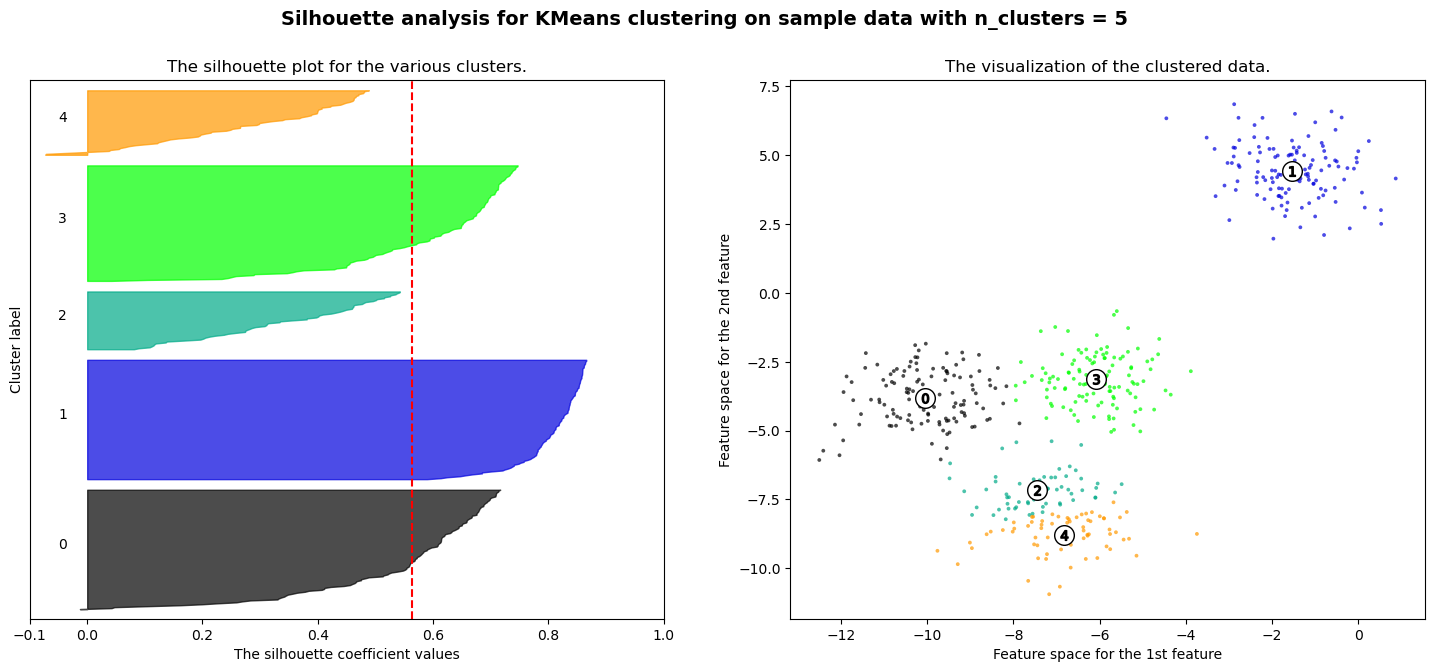

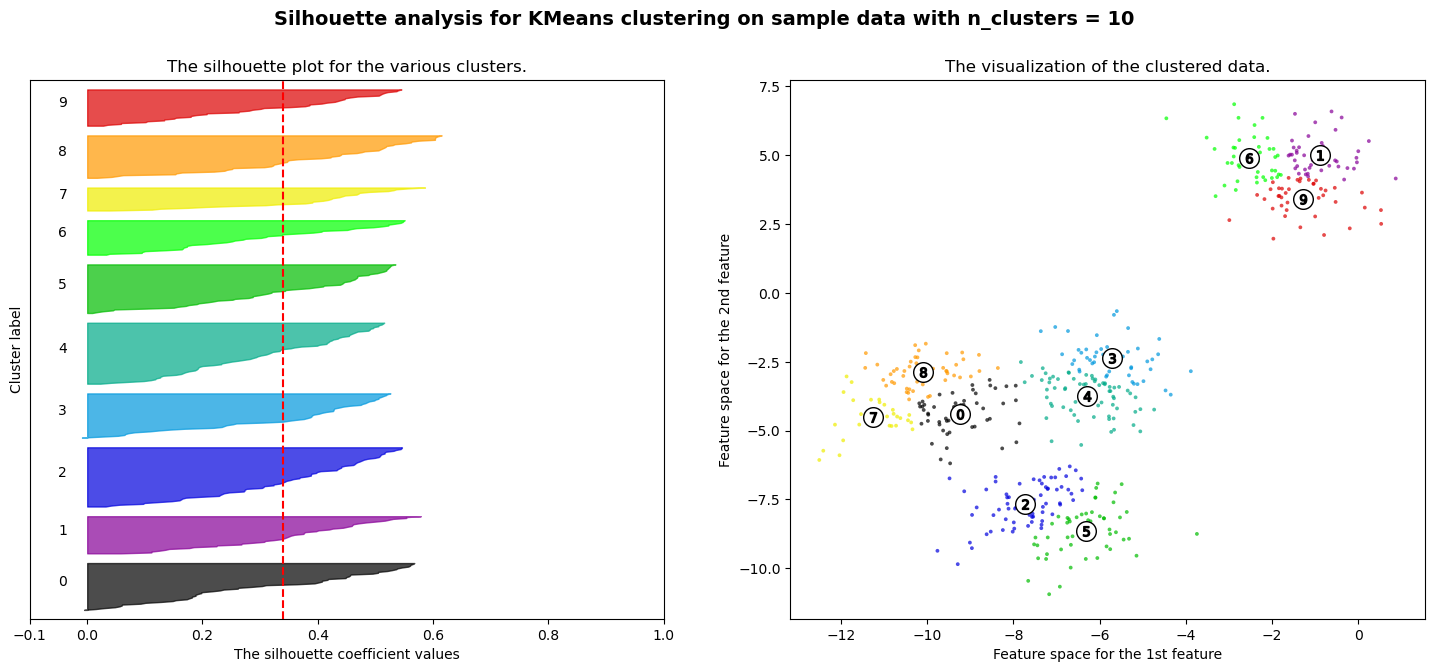

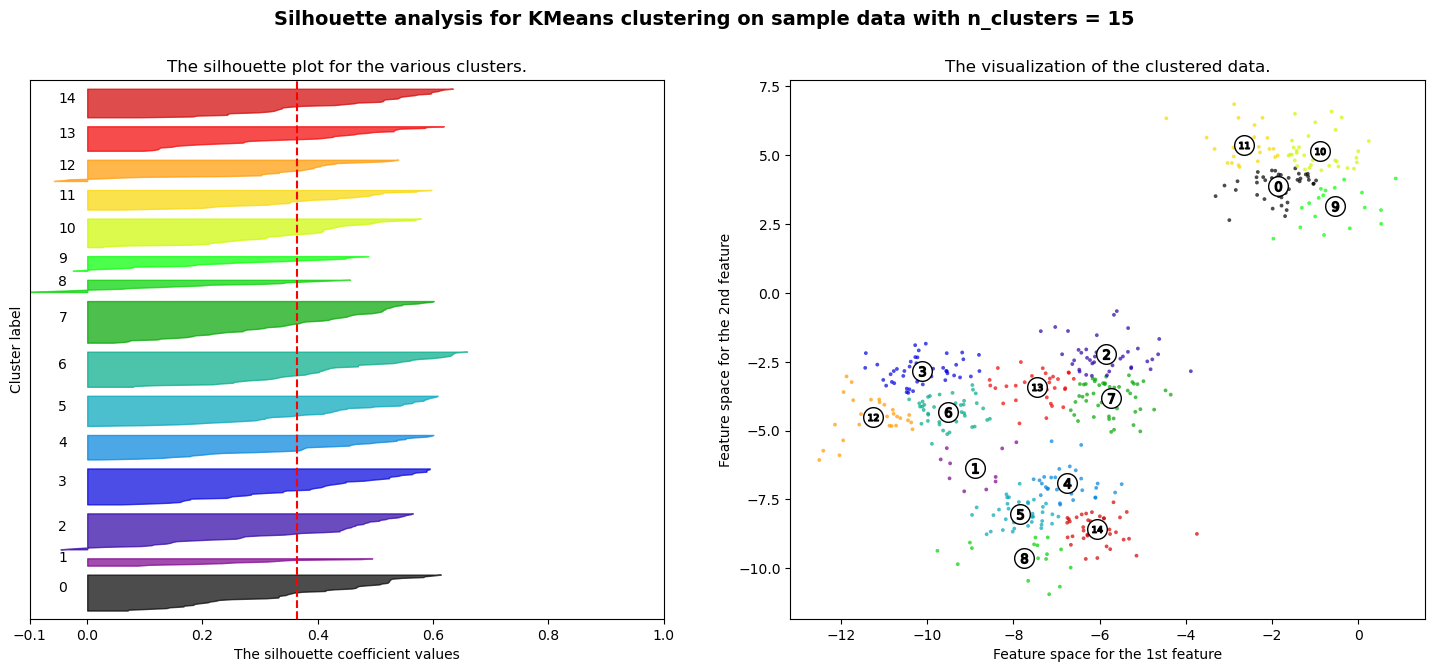

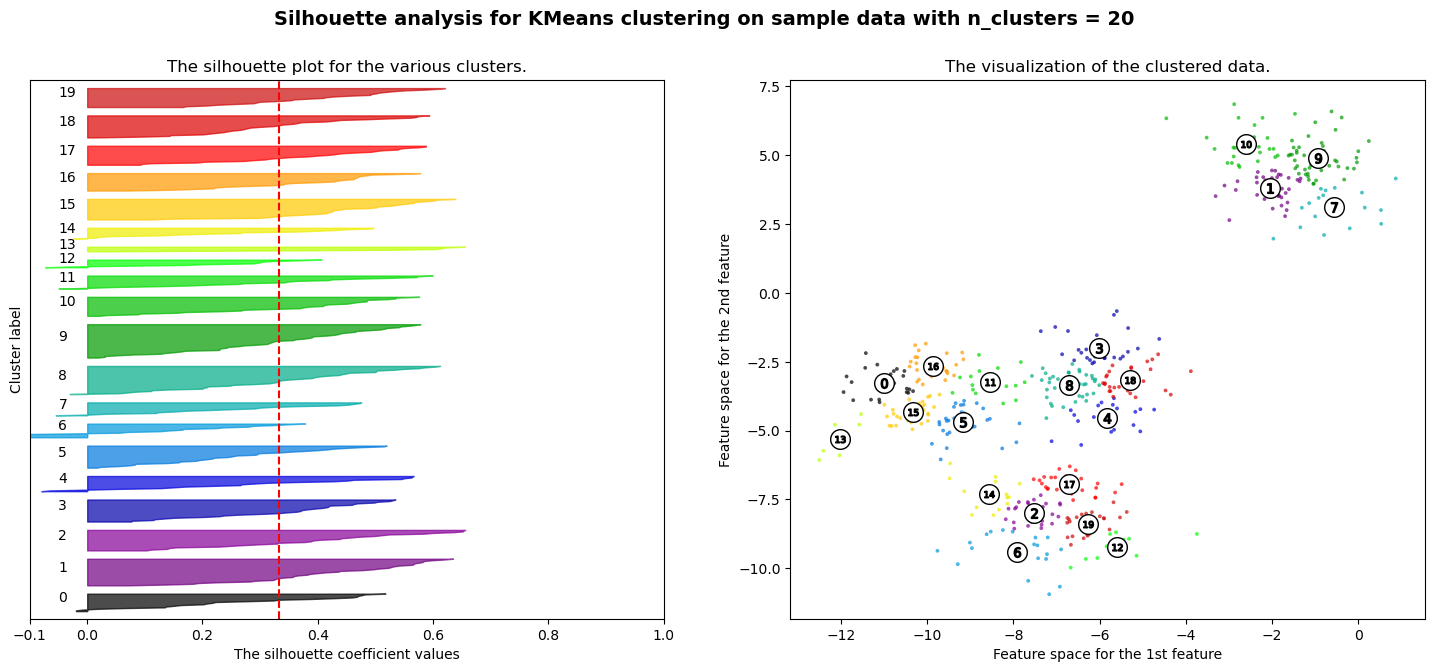

In [29]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [5,10, 15, 20]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()